# Model Random Forrest | Credit line

## Навигация

1. [Out-of-time и Train/Test разбивка](#Out-of-time-и-Train/Test-разбивка)
2. [Обучение](#Обучение)
   - [Оптимизация гиперпараметров с optuna](#Оптимизация-гиперпараметров-с-optuna)
   - [Refit](#Refit)
3. [поиск лучшего порога бинаризации](#поиск-лучшего-порога-бинаризации)
4. [Model perfomance](#Model-perfomance)
   - [Train perfomance](#Train-perfomance)
   - [Test perfomance](#Test-perfomance)
   - [Out-of-time perfomance](#Out-of-time-perfomance)
      - [January](#January)
      - [February](#February)
      - [March](#March)
      - [Out of time together](#Out-of-time-together)
5. [Gini OOT STD](#Gini-OOT-STD)      
6. [PSI](#PSI)
7. [SHAP values](#SHAP-values)

In [86]:
import joblib
import sys

sys.path.append("..")
import os

import pandas as pd

pd.set_option("display.max_columns", None)
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.calibration import (
    CalibratedClassifierCV,
    calibration_curve,
    CalibrationDisplay,
)

from feature_engine.selection import DropHighPSIFeatures

import utils
from utils.classification import my_binary_classification_report
from utils.business import approval_rate_plot
from utils.custom_column_transformers import GenAge, AsCategory, GenDataFromDatetime

import src

In [2]:
RAW_DATA_PATH = os.path.join("..", "data", "raw", "raw.csv")

CL_RF_MODEL_PATH = os.path.join("..", "models", "req_amount", "rf.pkl")
CALIBRATED_MODEL_PATH = os.path.join("..", "models", "calibrated", "calibrated_rf.pkl")

In [3]:
data = pd.read_csv(
    RAW_DATA_PATH,
    index_col="AppId",
    parse_dates=["dtstart", "birthday"],
    usecols=[
        # origin
        "AppId",
        "dtstart",
        "birthday",
        "sex",
        "citizenshipid",
        "martialid",
        "dependents",
        "sitename",
        "DOC",
        "averagemonthlyincome",
        "requested_amount",
        # nbki
        "Days_since_last_credit",
        "Max_overdue",
        # equifax
        "Nb_delays_90plus_ever_eq",
        "CH_length_eq",
        "S_hare_active_credit",
        # megafon/mail
        "Score",
        "MatchingLevel",
        "LIFETIMEBINValueId",
        "INTEGRALSCOREValueId",
        "60_6mob",
    ],
)

data = data.query('dtstart < "2023-09-01"')
data["60_6mob"] = data["60_6mob"].apply(
    lambda x: 0 if str(x) == "0.0" else 1
)  # Предобработка таргета

data = data.sort_values("dtstart")

data.head()

,dtstart,sex,birthday,citizenshipid,martialid,dependents,sitename,DOC,averagemonthlyincome,Days_since_last_credit,Max_overdue,Nb_delays_90plus_ever_eq,CH_length_eq,S_hare_active_credit,Score,MatchingLevel,INTEGRALSCOREValueId,LIFETIMEBINValueId,60_6mob,requested_amount
AppId,,,,,,,,,,,,,,,,,,,,
617650,2019-09-26 13:19:00,2.0,1960-11-08,860,3.0,0,www.maximus.ru,2.0,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.064780,5.0,0,13454.0
620164,2019-09-27 11:13:00,1.0,1988-07-10,762,1.0,0,www.maximus.ru,1.0,45000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.078340,5.0,0,19172.3
631492,2019-10-04 18:29:00,1.0,1989-02-14,762,2.0,1,www.megafon.ru,1.0,100000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.134316,4.0,0,12453.7
637036,2019-10-08 20:50:00,1.0,1995-07-10,762,1.0,0,www.megafon.ru,NaN,60000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.272594,1.0,0,23069.2
639263,2019-10-10 14:03:00,1.0,1990-10-30,762,2.0,1,www.megafon.ru,1.0,70000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.097222,5.0,0,26940.9


In [4]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 24486 entries, 617650 to 2265216
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   dtstart                   24486 non-null  datetime64[ns]
 1   sex                       24398 non-null  float64       
 2   birthday                  24486 non-null  datetime64[ns]
 3   citizenshipid             24486 non-null  int64         
 4   martialid                 24478 non-null  float64       
 5   dependents                24486 non-null  int64         
 6   sitename                  24486 non-null  object        
 7   DOC                       23007 non-null  float64       
 8   averagemonthlyincome      24486 non-null  int64         
 9   Days_since_last_credit    22113 non-null  float64       
 10  Max_overdue               22113 non-null  float64       
 11  Nb_delays_90plus_ever_eq  4027 non-null   float64       
 12  CH_length_eq    

In [5]:
int_cols = [
    "age",
    "day",
    "dependents",
    "averagemonthlyincome",
    "Days_since_last_credit",
    "Max_overdue",
    "Nb_delays_90plus_ever_eq",
    "CH_length_eq",
    "LIFETIMEBINValueId",
]

cat_cols = [
    "sex",
    "weekday",
    "hour",
    "citizenshipid",
    "martialid",
    "sitename",
    "DOC",
    "MatchingLevel",
]

float_cols = [
    "INTEGRALSCOREValueId",
    "Score",
    "requested_amount",
    "S_hare_active_credit",
]

## Out-of-time и Train/Test разбивка

[к навигации](#Навигация)

In [6]:
def get_X_y(df, index):
    X = df.loc[index].drop(
        columns=[
            "60_6mob",
        ]
    )
    y = df.loc[index, "60_6mob"]

    return X, y

In [7]:
# Out-of-time
other_index = data.query('"2021-08-01" <= dtstart < "2023-01-01"').index
january_index = data.query('"2023-01-01" <= dtstart < "2023-02-01"').index
february_index = data.query('"2023-02-01" <= dtstart < "2023-03-01"').index
march_index = data.query('"2023-03-01" <= dtstart < "2023-04-01"').index
oot_index = data.query('"2023-01-01" <= dtstart < "2023-04-01"').index

thresh_1_index = data.query('"2023-01-01" <= dtstart < "2023-05-01"').index
thresh_2_index = data.query('"2023-05-01" <= dtstart < "2023-07-01"').index

print(
    f'Размер обучающей выборки  {other_index.shape[0]} '
    f'(доля дефолтников {data.loc[other_index, "60_6mob"].mean():.2%}).\n'
    f'Размер ЯНВАРЬской выборки {january_index.shape[0]} '
    f'(доля дефолтников {data.loc[january_index, "60_6mob"].mean():.2%}).\n'
    f'Размер ФЕВРАЛЬской выборки {february_index.shape[0]} '
    f'(доля дефолтников {data.loc[february_index, "60_6mob"].mean():.2%}).\n'
    f'Размер МАРТовской выборки {march_index.shape[0]} '
    f'(доля дефолтников {data.loc[march_index, "60_6mob"].mean():.2%}).\n'
    f'Размер ВСЕ выборки out-of-time {oot_index.shape[0]} '
    f'(доля дефолтников {data.loc[oot_index, "60_6mob"].mean():.2%}).\n'
)

Размер обучающей выборки  12330 (доля дефолтников 23.58%).
Размер ЯНВАРЬской выборки 624 (доля дефолтников 18.11%).
Размер ФЕВРАЛЬской выборки 500 (доля дефолтников 17.80%).
Размер МАРТовской выборки 406 (доля дефолтников 18.23%).
Размер ВСЕ выборки out-of-time 1530 (доля дефолтников 18.04%).



In [8]:
X, y = get_X_y(data, data.index)
X_train, y_train = get_X_y(data, other_index)
X_january, y_january = get_X_y(data, january_index)
X_february, y_february = get_X_y(data, february_index)
X_march, y_march = get_X_y(data, march_index)
X_oot, y_oot = get_X_y(data, oot_index)

In [9]:
# подгрузим веса модели
# rf = joblib.load(CL_RF_MODEL_PATH)
# calibrated_rf = joblib.load(CALIBRATED_MODEL_PATH)

### Preprocessing pipeline
[к навигации](#Навигация)

In [46]:
cat_pipe = Pipeline(
    [
        ("categorizer", AsCategory()),
        (
            "encode",
            OrdinalEncoder(
                encoded_missing_value=-1,
                handle_unknown="use_encoded_value",
                unknown_value=-2,
            ),
        ),
    ]
)

int_pipe = Pipeline([("imputer", SimpleImputer())])

In [47]:
pretransform_1 = ColumnTransformer(
    [
        ("gen_age", GenAge(), ["dtstart", "birthday"]),
        ("gen_datetime_data", GenDataFromDatetime(), "dtstart"),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

pretransform_2 = ColumnTransformer(
    [
        ("cat_feature", cat_pipe, cat_cols),
        ("int_features", int_pipe, int_cols),
        ("float_features", int_pipe, float_cols),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [48]:
rf_feautre_step = Pipeline(
    [
        ("step_1", pretransform_1),
        ("step_2", pretransform_2),
        ("selection", SelectKBest(k=15)),
    ],
).set_output(transform="pandas")

In [49]:
rf_estimator = Pipeline(
    [
        ("feature", rf_feautre_step),
        ("model", RandomForestClassifier(random_state=42)),
        # ('model', CalibratedClassifierCV(RandomForestClassifier(random_state=42)))
    ]
)

In [52]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=50, stop=110, num=11)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 23, num=11)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 6, 8, 10, 12, 20, 30, 50]


random_grid = {
    "model__n_estimators": n_estimators,
    "model__max_depth": max_depth,
    "model__min_samples_split": min_samples_split,
    "model__min_samples_leaf": min_samples_leaf,
    # 'model__method': ['isotonic', 'sigmoid'],
}

In [53]:
rf_search = RandomizedSearchCV(
    estimator=rf_estimator,
    param_distributions=random_grid,
    n_iter=300,
    scoring=["f1", "roc_auc"],
    n_jobs=12,
    cv=TimeSeriesSplit(n_splits=5),
    verbose=1,
    return_train_score=True,
    refit="roc_auc",
)
rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('feature',
                                              Pipeline(steps=[('step_1',
                                                               ColumnTransformer(remainder='passthrough',
                                                                                 transformers=[('gen_age',
                                                                                                GenAge(),
                                                                                                ['dtstart',
                                                                                                 'birthday']),
                                                                                               ('gen_datetime_data',
                                                                                                GenDataFromDatetime(),
                                                                                                'dtstart')],
                                                                                 verbose_feature_names_out=False)),
                                                              ('step_...
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=300, n_jobs=12,
                   param_distributions={'model__max_depth': [3, 5, 7, 9, 11, 13,
                                                             15, 17, 19, 21,
                                                             23],
                                        'model__min_samples_leaf': [2, 4, 6, 8,
                                                                    10, 12, 20,
                                                                    30, 50],
                                        'model__min_samples_split': [2, 5, 10,
                                                                     20, 30],
                                        'model__n_estimators': [50, 56, 62, 68,
                                                                74, 80, 86, 92,
                                                                98, 104, 110]},
                   refit='roc_auc', return_train_score=True,
                   scoring=['f1', 'roc_auc'], verbose=1)

In [54]:
print("Лучшие гиперпараметры:")
for param, value in rf_search.best_params_.items():
    print(f"{param}: {value}")

Лучшие гиперпараметры:
model__n_estimators: 110
model__min_samples_split: 30
model__min_samples_leaf: 20
model__max_depth: 9


In [55]:
rf = rf_search.best_estimator_

In [56]:
# сохраним веса модели
joblib.dump(rf, CL_RF_MODEL_PATH)

['../models/req_amount/rf.pkl']

### Порог бинаризации
[к навигации](#Навигация)

лучший порог: 0.44644572127964166


0.44644572127964166

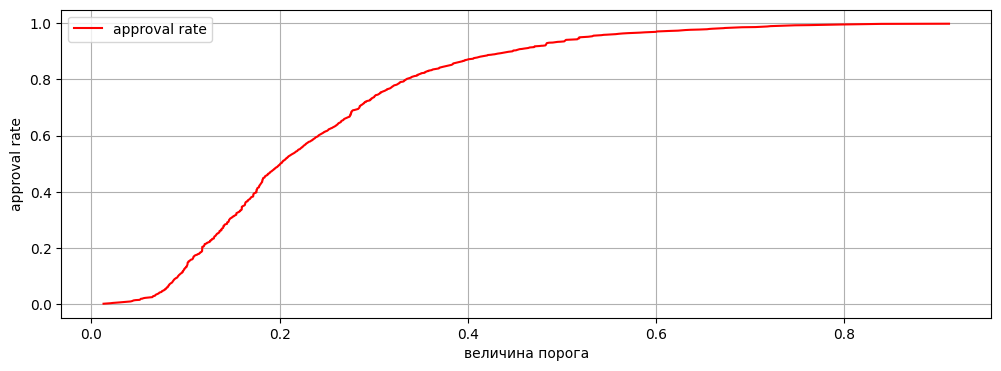

In [90]:
approval_rate_plot(calibrated_rf.predict_proba(X_train)[:, 1])

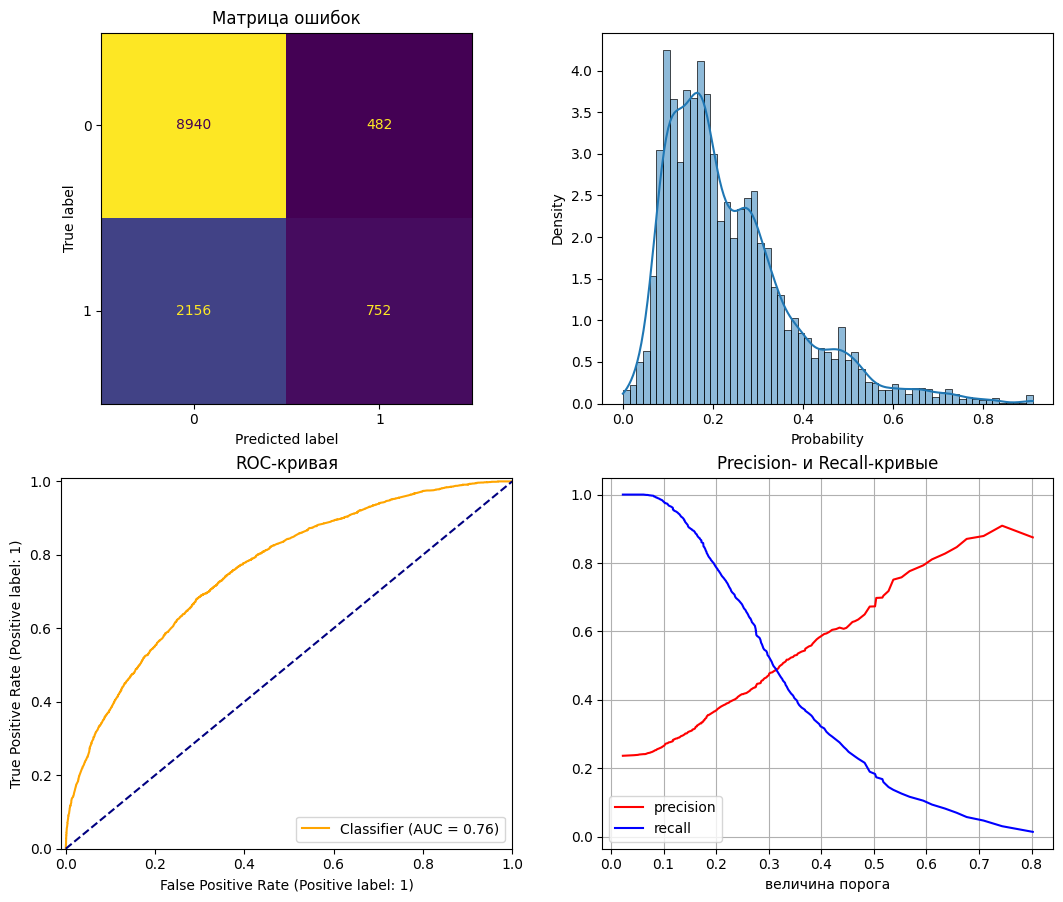

              precision    recall  f1-score   support

           0       0.81      0.95      0.87      9422
           1       0.61      0.26      0.36      2908

    accuracy                           0.79     12330
   macro avg       0.71      0.60      0.62     12330
weighted avg       0.76      0.79      0.75     12330

Индекс Gini = 0.5221902658678497


In [91]:
my_binary_classification_report(
    classifier=calibrated_rf, X=X_train, y_true=y_train, threshold=0.446
)

### Out of time perfomance
[к навигации](#Навигация)

#### January
[к навигации](#Навигация)

лучший порог: 0.3025449237674483


0.3025449237674483

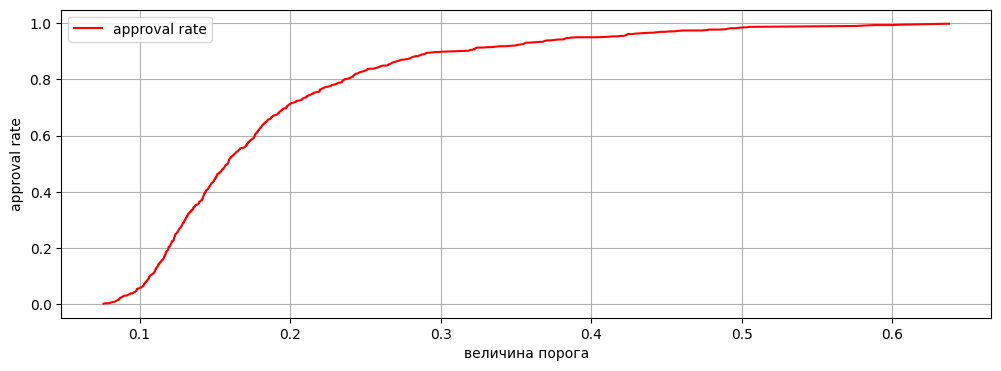

In [21]:
approval_rate_plot(rf.predict_proba(X_january)[:, 1])

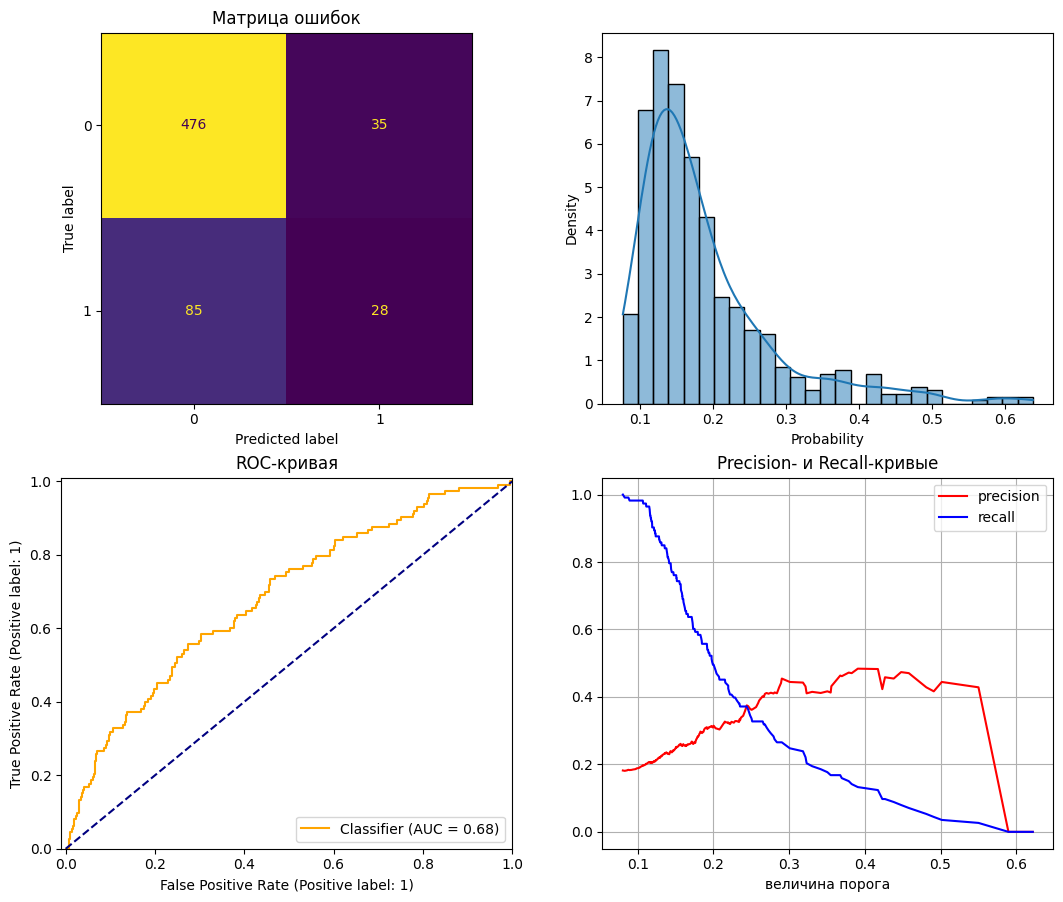

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       511
           1       0.44      0.25      0.32       113

    accuracy                           0.81       624
   macro avg       0.65      0.59      0.60       624
weighted avg       0.78      0.81      0.78       624

Индекс Gini = 0.365152486015621


In [22]:
my_binary_classification_report(
    classifier=rf, X=X_january, y_true=y_january, threshold=0.302
)

#### February
[к навигации](#Навигация)

лучший порог: 0.31942404590698176


0.31942404590698176

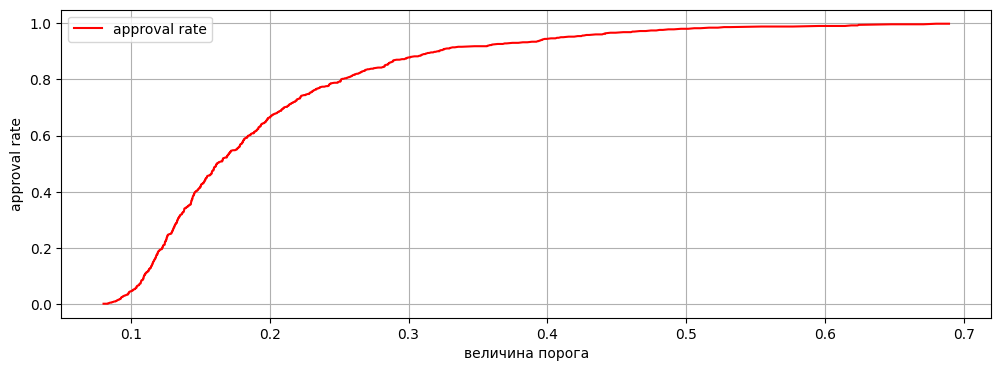

In [23]:
approval_rate_plot(rf.predict_proba(X_february)[:, 1])

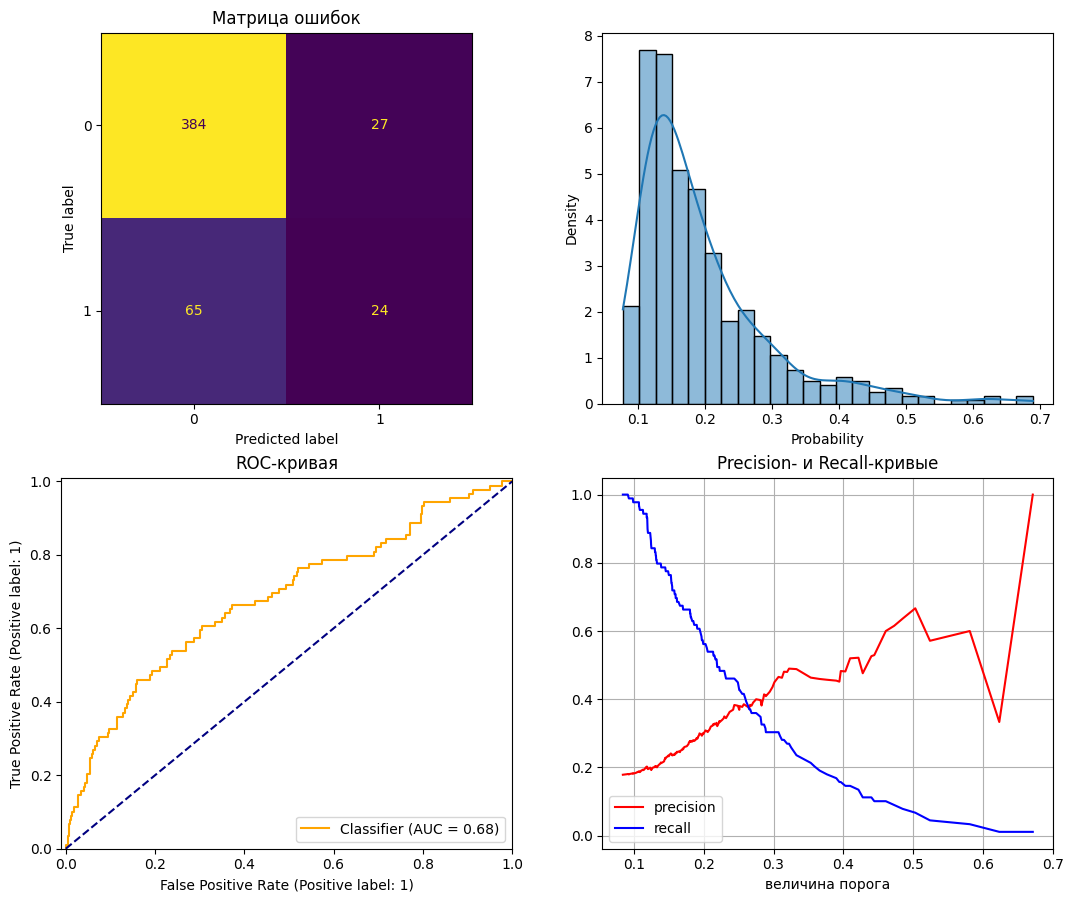

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       411
           1       0.47      0.27      0.34        89

    accuracy                           0.82       500
   macro avg       0.66      0.60      0.62       500
weighted avg       0.79      0.82      0.80       500

Индекс Gini = 0.3616555947401514


In [24]:
my_binary_classification_report(
    classifier=rf,
    X=X_february,
    y_true=y_february,
    threshold=0.319,
)

#### March
[к навигации](#Навигация)

лучший порог: 0.35205501816545204


0.35205501816545204

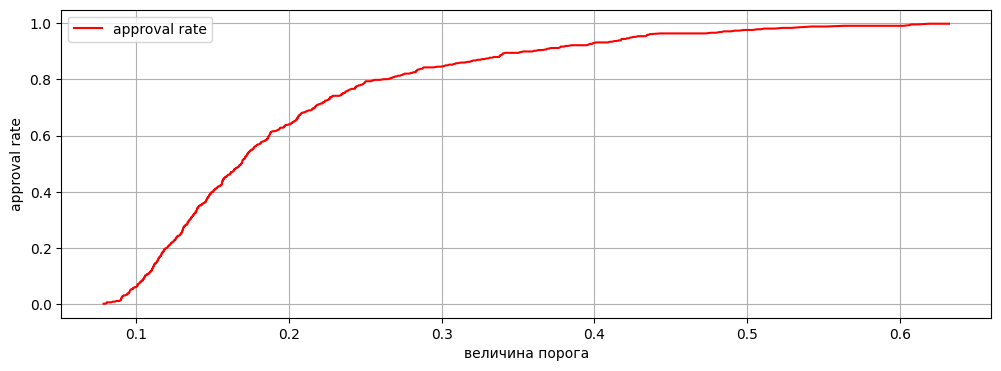

In [25]:
approval_rate_plot(rf.predict_proba(X_march)[:, 1])

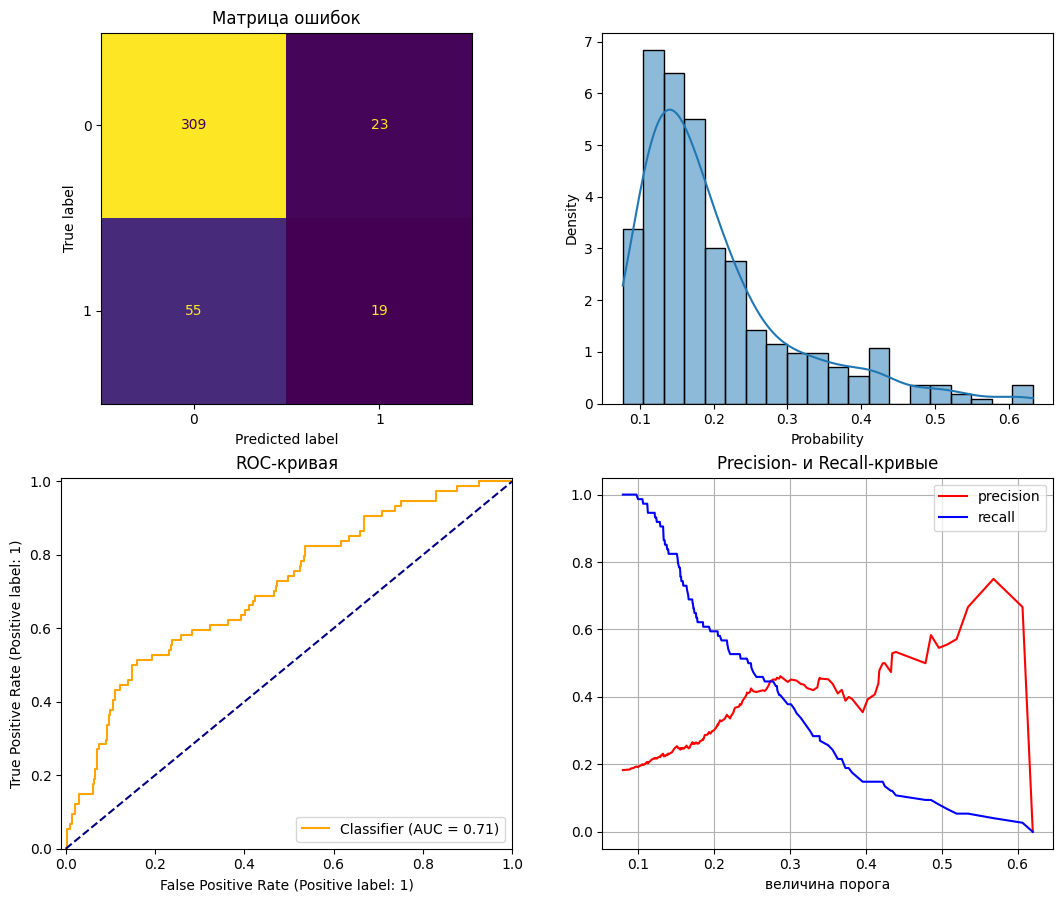

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       332
           1       0.45      0.26      0.33        74

    accuracy                           0.81       406
   macro avg       0.65      0.59      0.61       406
weighted avg       0.78      0.81      0.79       406

Индекс Gini = 0.4162324975577989


In [26]:
my_binary_classification_report(
    classifier=rf, X=X_march, y_true=y_march, threshold=0.352
)

### Out of time together
[к навигации](#Навигация)

лучший порог: 0.33424945075509205


0.33424945075509205

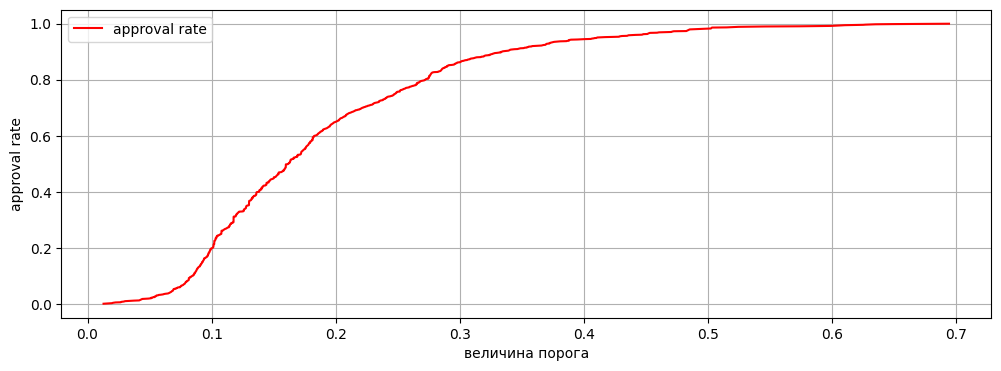

In [27]:
approval_rate_plot(rf.predict_proba(X_oot)[:, 1])

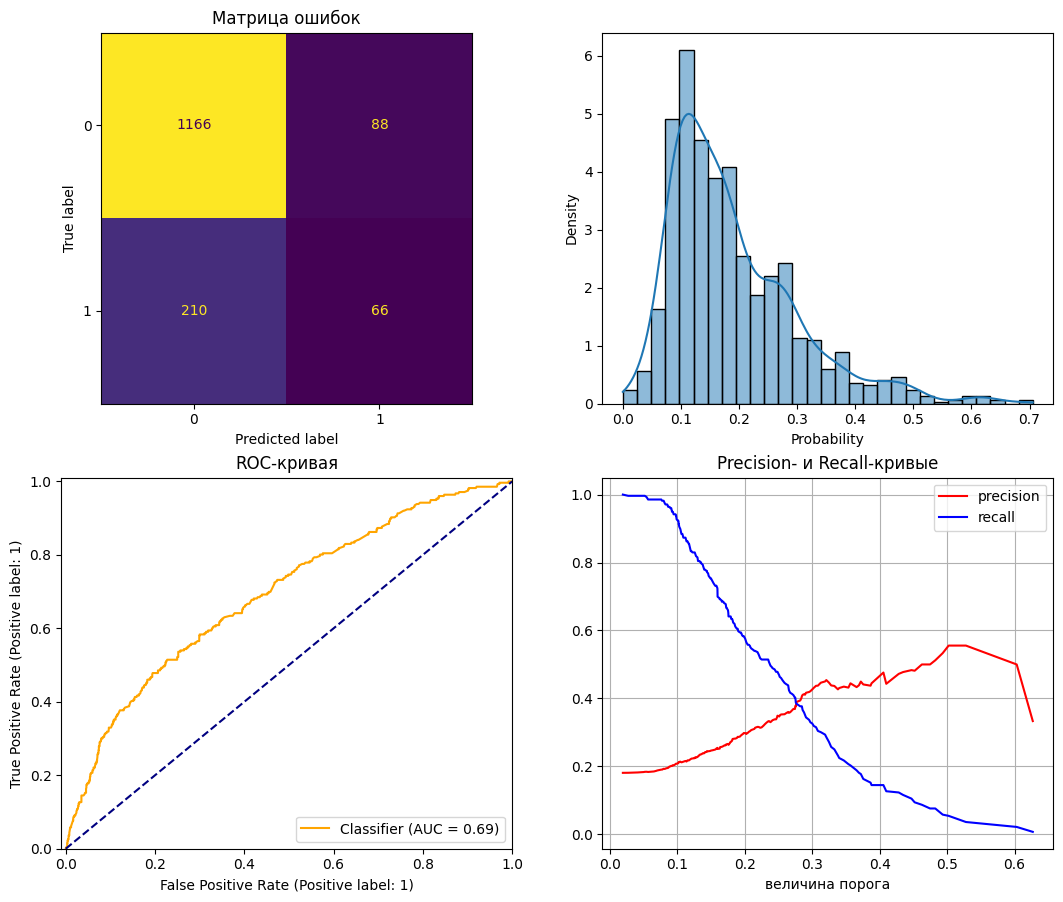

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1254
           1       0.43      0.24      0.31       276

    accuracy                           0.81      1530
   macro avg       0.64      0.58      0.60      1530
weighted avg       0.77      0.81      0.78      1530

Индекс Gini = 0.38306116080715613


In [28]:
my_binary_classification_report(classifier=rf, X=X_oot, y_true=y_oot, threshold=0.334)

### Gini OOT STD
[к навигации](#Навигация)

In [29]:
all_gini = [0.365152486015621, 0.3616555947401514, 0.4162324975577989]
round(np.std(all_gini), 2)

0.02

### PSI proba
[к навигации](#Навигация)

In [30]:
psi_df = rf[0].transform(X)
psi_df["dtstart"] = X["dtstart"]
psi_df["proba"] = rf.predict_proba(X)[:, 1]
psi_df = psi_df.query('"2021-08-01" <= dtstart < "2023-04-01"')

In [31]:
psi_transformer = DropHighPSIFeatures(split_col="dtstart", cut_off=("2023-01-01"))
psi_transformer.fit(psi_df[["dtstart", "proba"]])
psi_transformer.psi_values_

{'proba': 0.15595120285943778}

### SHAP
[к навигации](#Навигация)

In [9]:
model = rf.named_steps["model"]
preprocess = rf.named_steps["feature"]
# X_train_shap = preprocess.transform(X_train)
# X_jan_shap = preprocess.transform(X_january)
# X_feb_shap = preprocess.transform(X_february)
# X_march_shap = preprocess.transform(X_march)
# X_oot_shap = preprocess.transform(X_oot)

In [10]:
explainer = shap.TreeExplainer(model)

In [11]:
cols_dict = {
    "S_hare_active_credit": "S_hare_active_credit_eq",
    "Score": "MailRu_Score",
    "MatchingLevel": "MailRu_MatchingLevel",
    "INTEGRALSCOREValueId": "MGFN_INTEGRALSCOREValueId",
    "LIFETIMEBINValueId": "MGFN_LIFETIMEBINValueId",
}

In [61]:
# X_train_shap.rename(columns=cols_dict, inplace=True)
# X_jan_shap.rename(columns=cols_dict, inplace=True)
# X_feb_shap.rename(columns=cols_dict, inplace=True)
# X_march_shap.rename(columns=cols_dict, inplace=True)
# X_oot_shap.rename(columns=cols_dict, inplace=True)

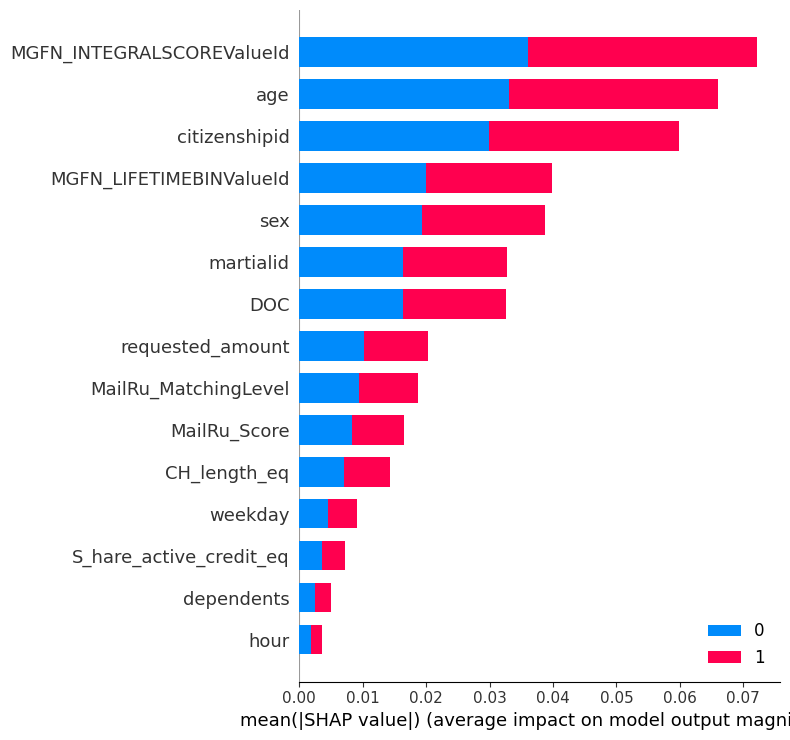

In [62]:
# train
shap.summary_plot(
    shap_values=explainer.shap_values(X_train_shap),
    features=X_train_shap,
    class_names=[0, 1],
    max_display=15,
)

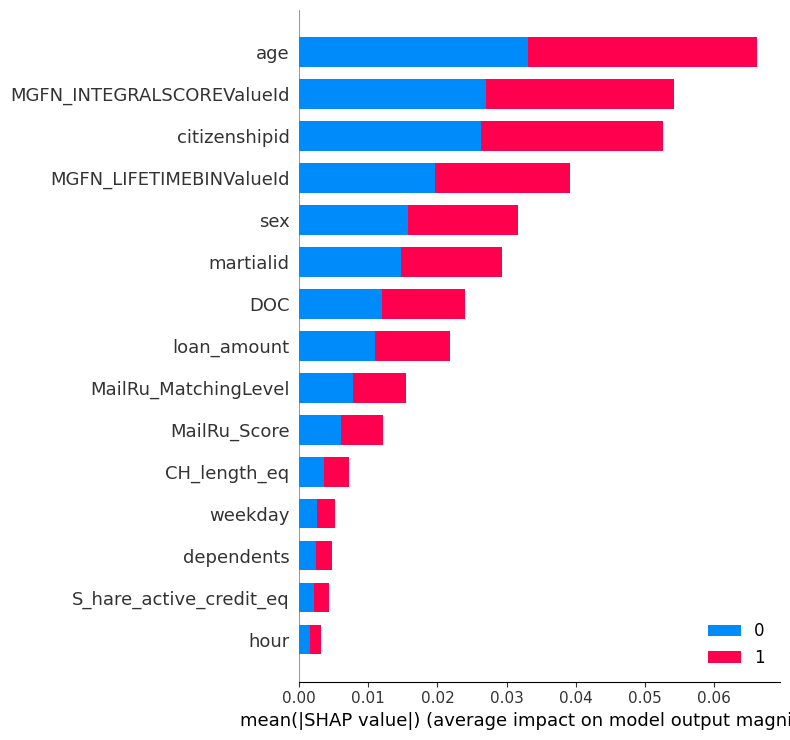

In [31]:
# january
shap.summary_plot(
    shap_values=explainer.shap_values(X_jan_shap),
    features=X_jan_shap,
    class_names=[0, 1],
    max_display=22,
)

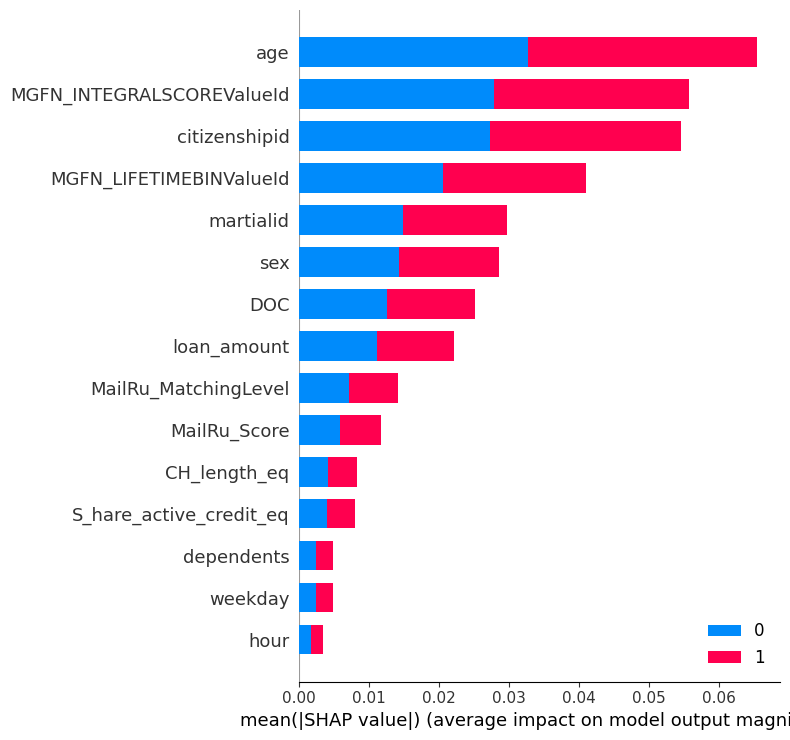

In [32]:
# february
shap.summary_plot(
    shap_values=explainer.shap_values(X_feb_shap),
    features=X_feb_shap,
    class_names=[0, 1],
    max_display=22,
)

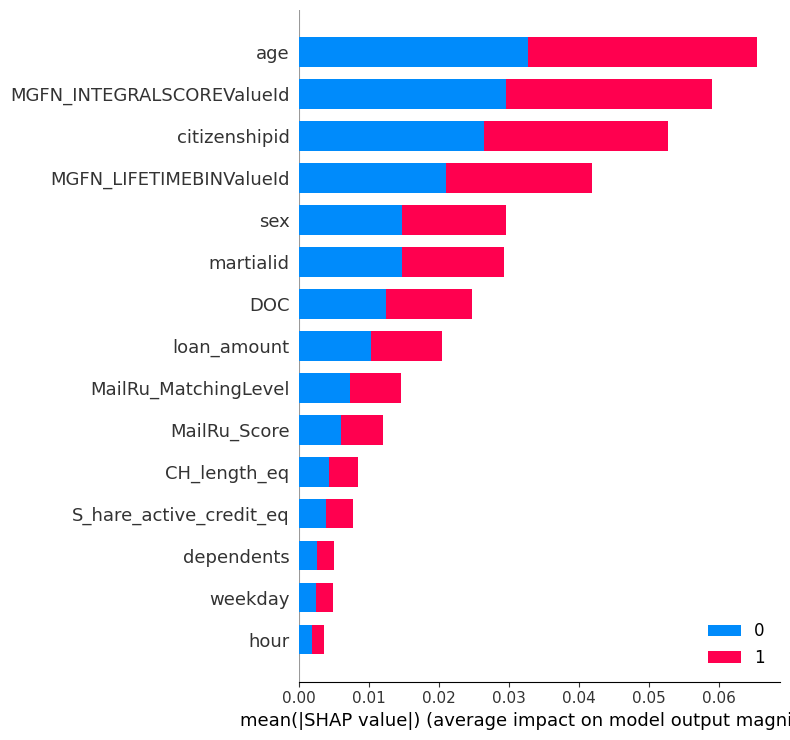

In [33]:
# march
shap.summary_plot(
    shap_values=explainer.shap_values(X_march_shap),
    features=X_march_shap,
    class_names=[0, 1],
    max_display=22,
)

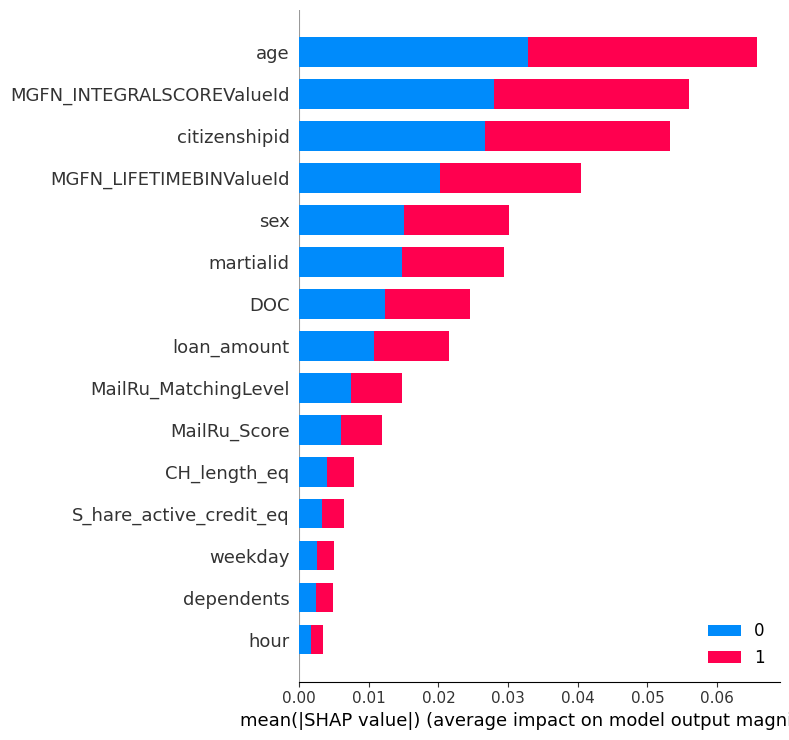

In [34]:
# oot
shap.summary_plot(
    shap_values=explainer.shap_values(X_oot_shap),
    features=X_oot_shap,
    class_names=[0, 1],
    max_display=15,
)

# Вызревшие данные

In [92]:
april_index = data.query('"2023-04-01" <= dtstart < "2023-05-01"').index
may_index = data.query('"2023-05-01" <= dtstart < "2023-06-01"').index
june_index = data.query('"2023-06-01" <= dtstart < "2023-07-01"').index
july_index = data.query('"2023-07-01" <= dtstart < "2023-08-01"').index
august_index = data.query('"2023-08-01" <= dtstart').index
all_new = data.query('"2023-04-01" <= dtstart').index

In [93]:
print(
    f'Размер Aпрельской выборки {april_index.shape[0]} '
    f'(доля дефолтников {data.loc[april_index, "60_6mob"].mean():.2%}).\n'
    f'Размер Майской выборки {may_index.shape[0]} '
    f'(доля дефолтников {data.loc[may_index, "60_6mob"].mean():.2%}).\n'
    f'Размер Июньской выборки {june_index.shape[0]} '
    f'(доля дефолтников {data.loc[june_index, "60_6mob"].mean():.2%}).\n'
    f'Размер Июльской выборки {july_index.shape[0]} '
    f'(доля дефолтников {data.loc[july_index, "60_6mob"].mean():.2%}).\n'
    f'Размер Августовской выборки {august_index.shape[0]} '
    f'(доля дефолтников {data.loc[august_index, "60_6mob"].mean():.2%}).\n'
    f'Размер OOT выборки {all_new.shape[0]} '
    f'(доля дефолтников {data.loc[all_new, "60_6mob"].mean():.2%}).\n'
)

Размер Aпрельской выборки 329 (доля дефолтников 20.36%).
Размер Майской выборки 113 (доля дефолтников 18.58%).
Размер Июньской выборки 112 (доля дефолтников 10.71%).
Размер Июльской выборки 133 (доля дефолтников 19.55%).
Размер Августовской выборки 139 (доля дефолтников 16.55%).
Размер OOT выборки 826 (доля дефолтников 18.04%).



In [94]:
X_new, y_new = get_X_y(data, all_new)
X_april, y_april = get_X_y(data, april_index)
X_may, y_may = get_X_y(data, may_index)
X_june, y_june = get_X_y(data, june_index)
X_july, y_july = get_X_y(data, july_index)
X_august, y_august = get_X_y(data, august_index)

## Все вызревшие

лучший порог: 0.3271858312710984


0.3271858312710984

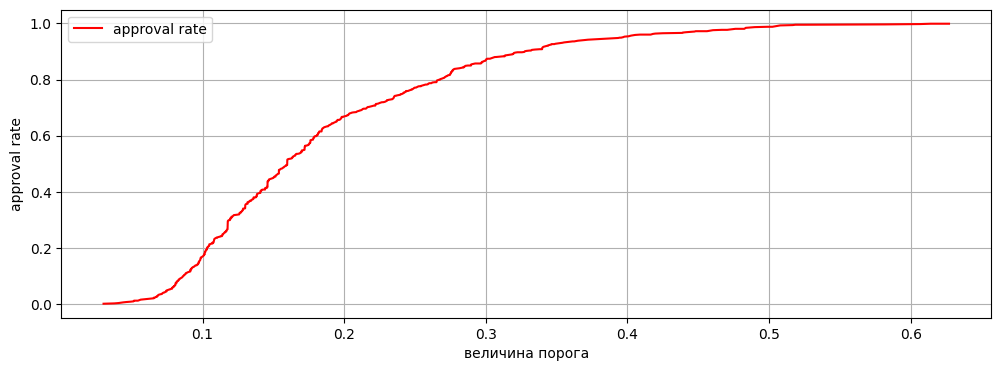

In [105]:
approval_rate_plot(
    calibrated_rf.predict_proba(X_new)[:, 1],
)

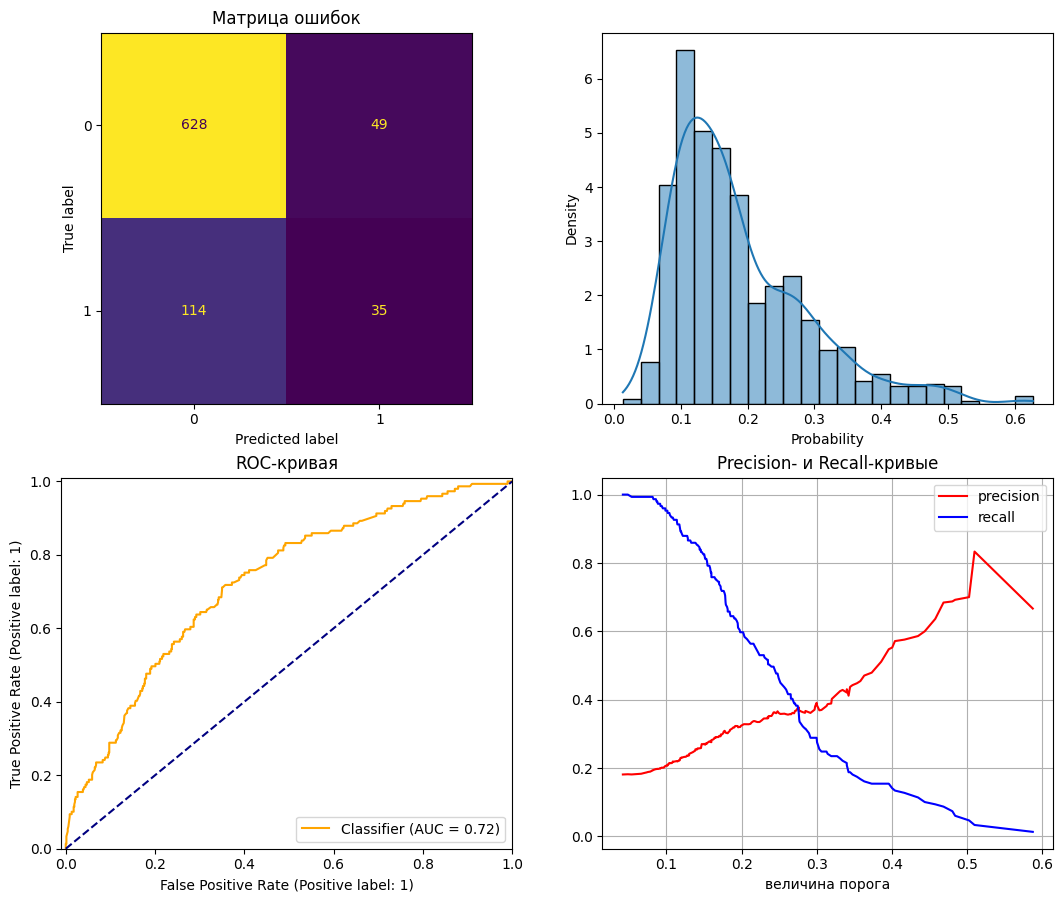

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       677
           1       0.42      0.23      0.30       149

    accuracy                           0.80       826
   macro avg       0.63      0.58      0.59       826
weighted avg       0.77      0.80      0.78       826

Индекс Gini = 0.4486136032436827


In [106]:
my_binary_classification_report(
    classifier=calibrated_rf, X=X_new, y_true=y_new, threshold=0.327
)

### April

лучший порог: 0.33984554318081034


0.33984554318081034

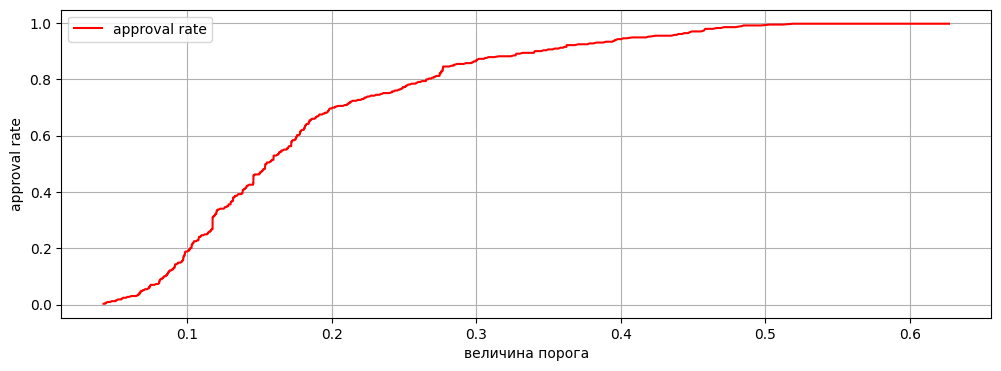

In [107]:
approval_rate_plot(
    calibrated_rf.predict_proba(X_april)[:, 1],
)

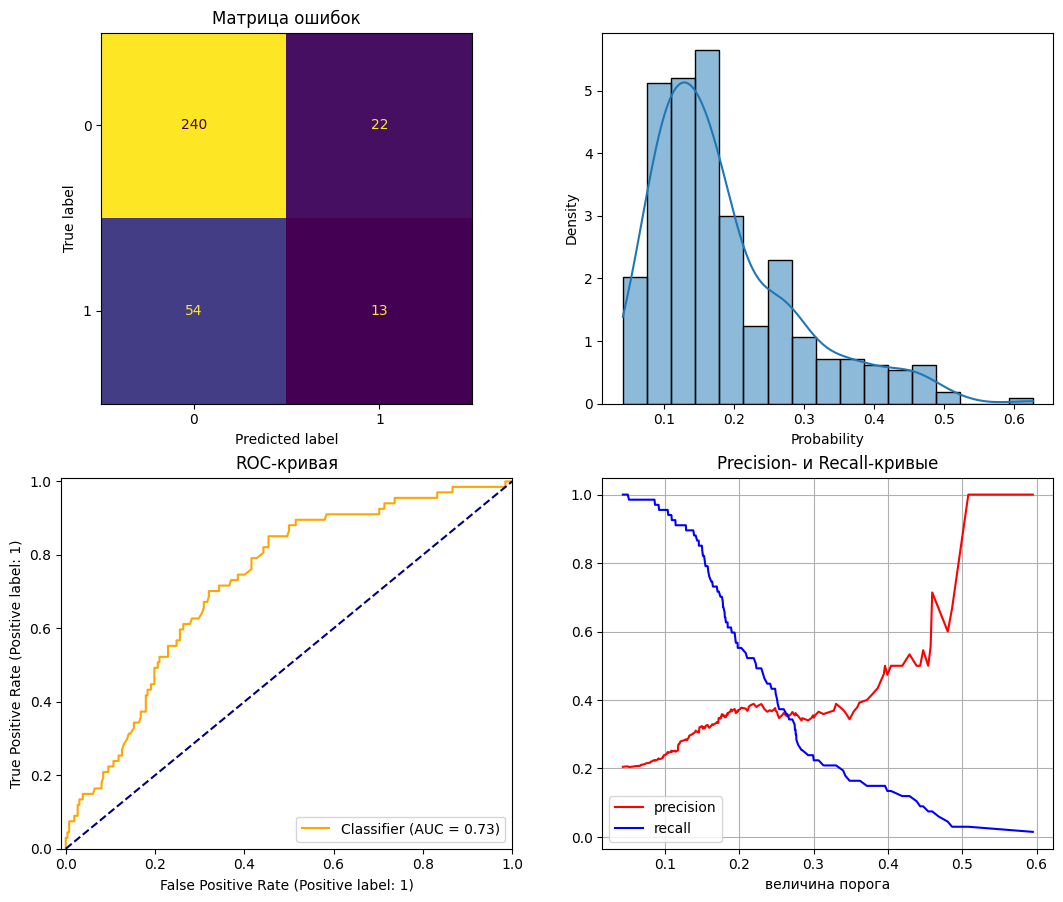

              precision    recall  f1-score   support

           0       0.82      0.92      0.86       262
           1       0.37      0.19      0.25        67

    accuracy                           0.77       329
   macro avg       0.59      0.56      0.56       329
weighted avg       0.73      0.77      0.74       329

Индекс Gini = 0.455223880597015


In [108]:
my_binary_classification_report(
    classifier=calibrated_rf, X=X_april, y_true=y_april, threshold=0.339
)

### May

лучший порог: 0.31965127527376674


0.31965127527376674

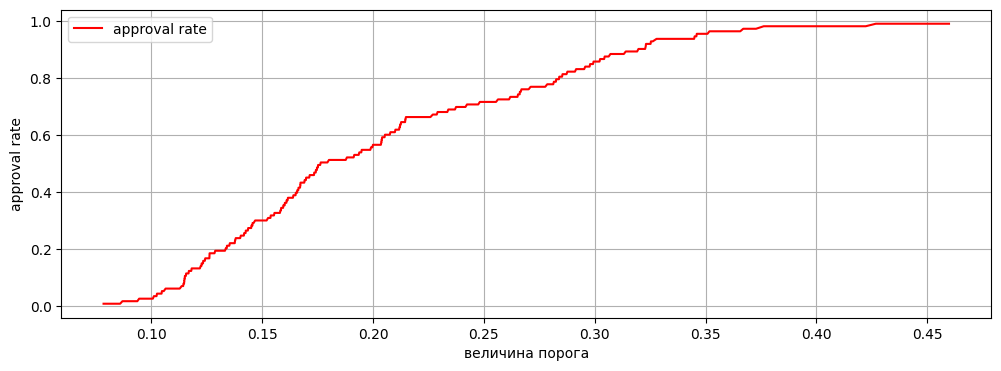

In [64]:
approval_rate_plot(
    rf.predict_proba(X_may)[:, 1],
)

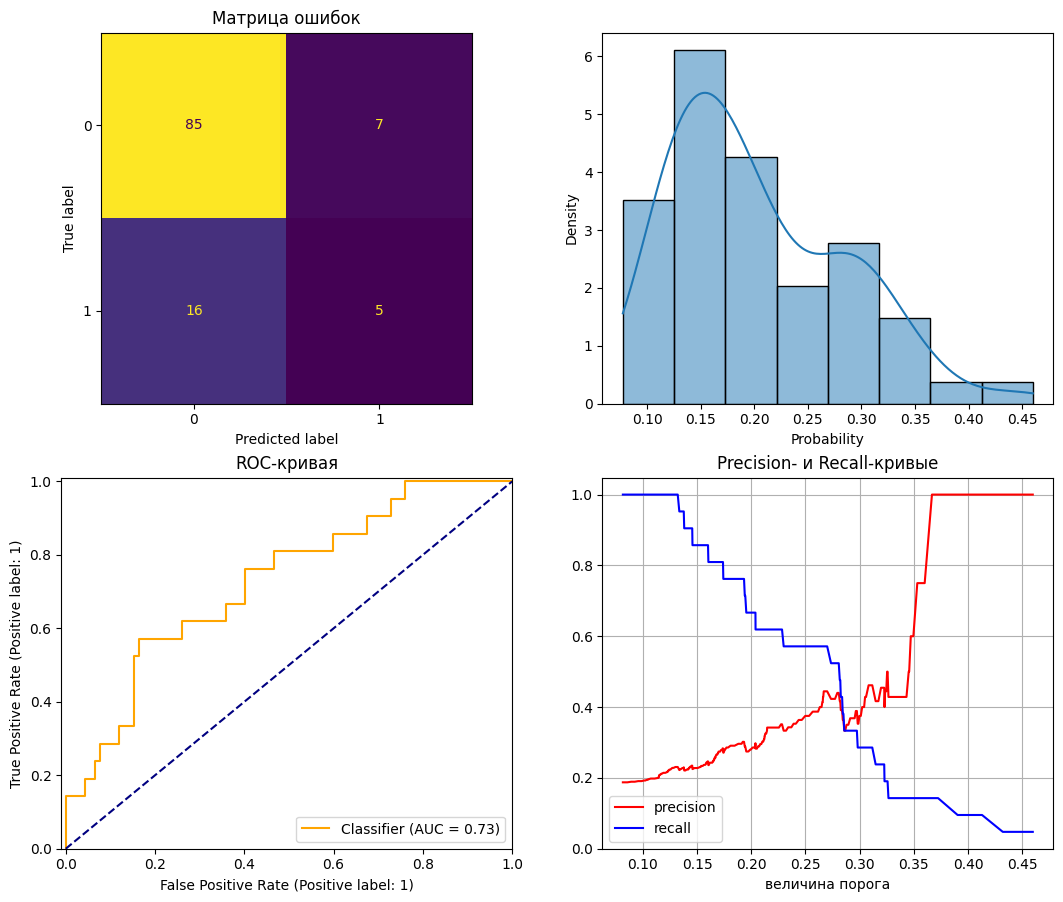

              precision    recall  f1-score   support

           0       0.84      0.92      0.88        92
           1       0.42      0.24      0.30        21

    accuracy                           0.80       113
   macro avg       0.63      0.58      0.59       113
weighted avg       0.76      0.80      0.77       113

Индекс Gini = 0.45445134575569357


In [65]:
my_binary_classification_report(classifier=rf, X=X_may, y_true=y_may, threshold=0.319)

### June

лучший порог: 0.3091167478894529


0.3091167478894529

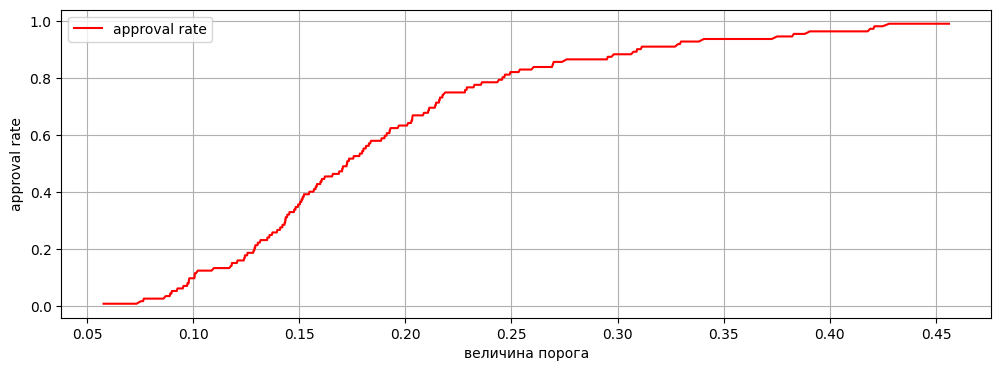

In [66]:
approval_rate_plot(
    rf.predict_proba(X_june)[:, 1],
)

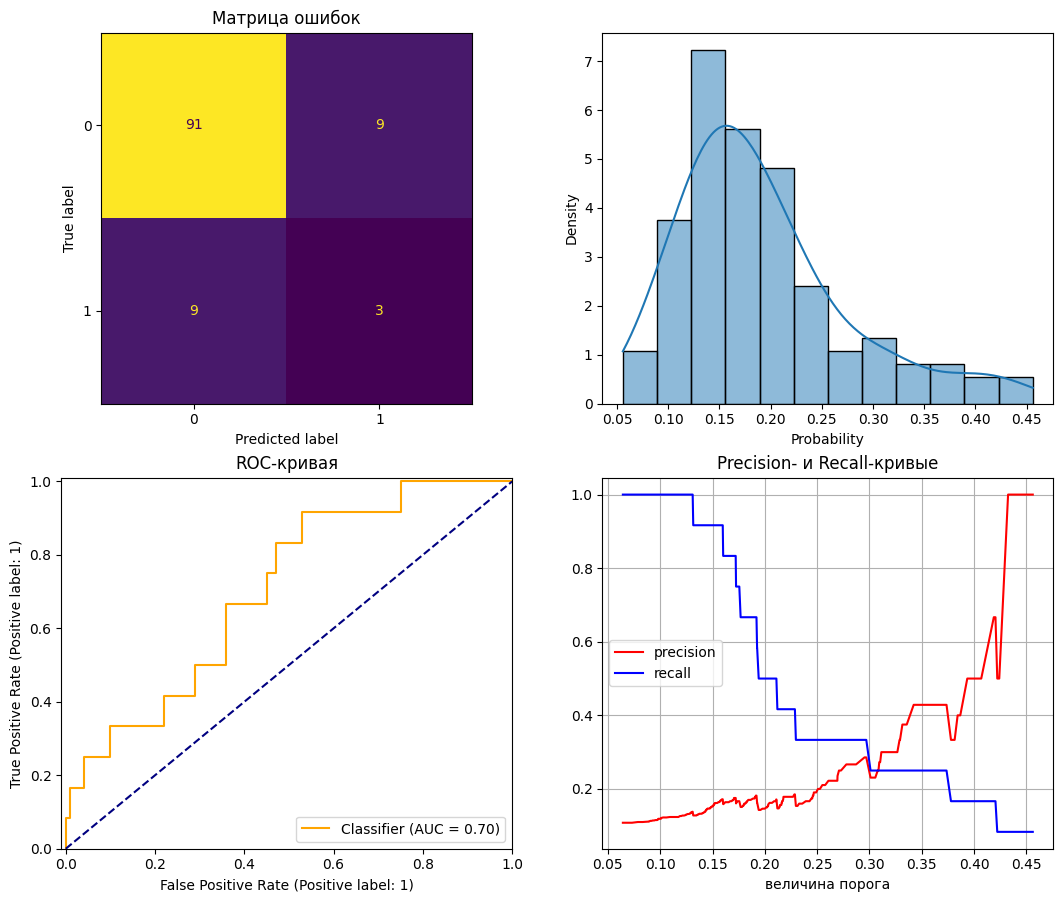

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       100
           1       0.25      0.25      0.25        12

    accuracy                           0.84       112
   macro avg       0.58      0.58      0.58       112
weighted avg       0.84      0.84      0.84       112

Индекс Gini = 0.4033333333333333


In [67]:
my_binary_classification_report(classifier=rf, X=X_june, y_true=y_june, threshold=0.309)

### July

лучший порог: 0.3000733689770818


0.3000733689770818

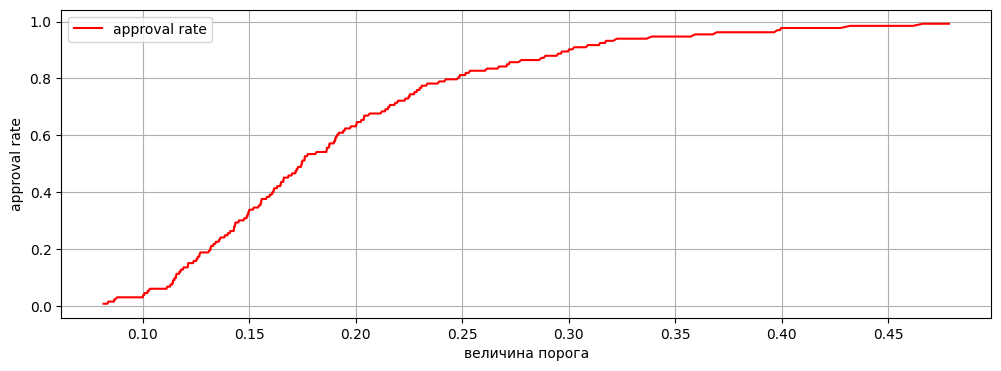

In [68]:
approval_rate_plot(rf.predict_proba(X_july)[:, 1])

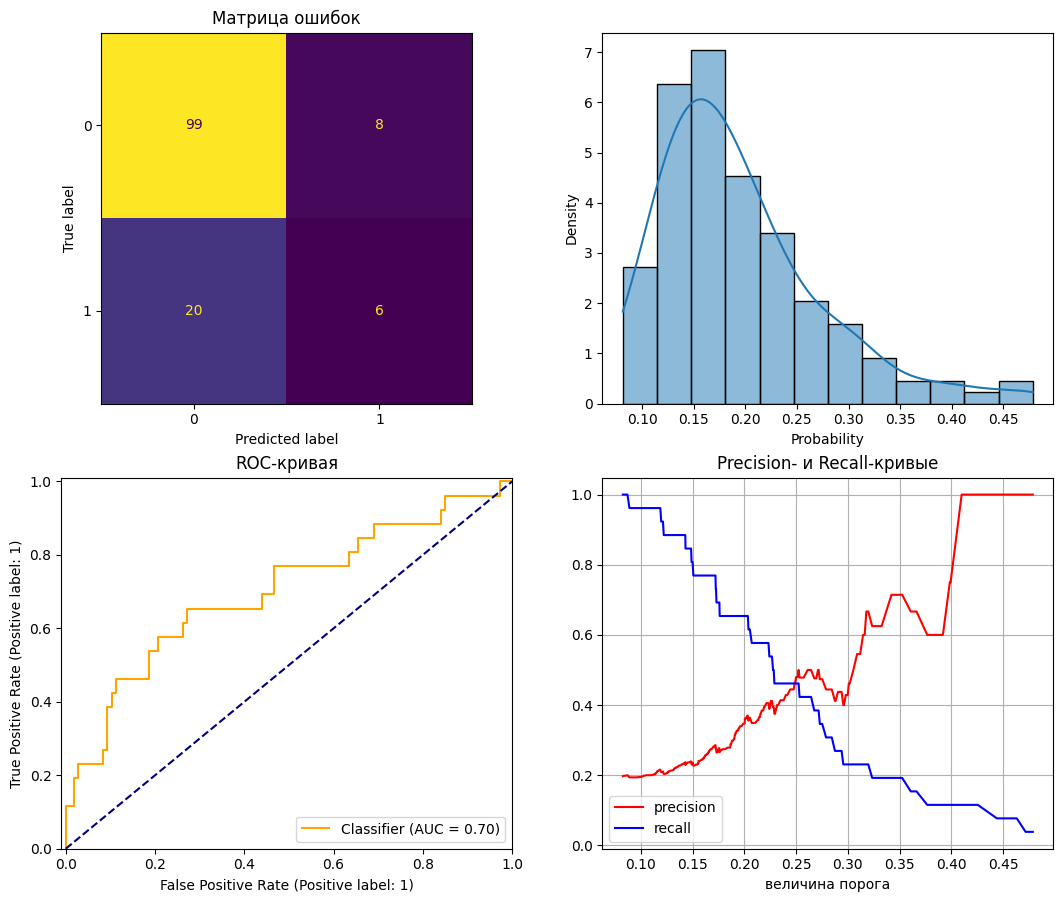

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       107
           1       0.43      0.23      0.30        26

    accuracy                           0.79       133
   macro avg       0.63      0.58      0.59       133
weighted avg       0.75      0.79      0.76       133

Индекс Gini = 0.40186915887850483


In [69]:
my_binary_classification_report(classifier=rf, X=X_july, y_true=y_july, threshold=0.300)

### August

лучший порог: 0.31349860161881604


0.31349860161881604

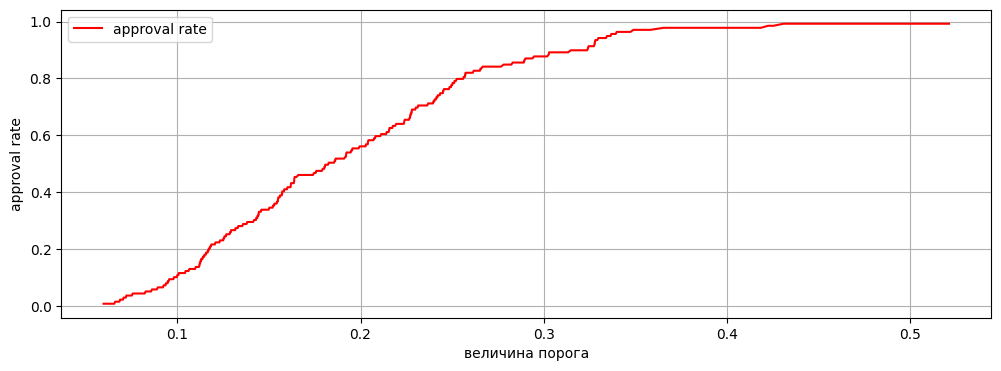

In [70]:
approval_rate_plot(rf.predict_proba(X_august)[:, 1])

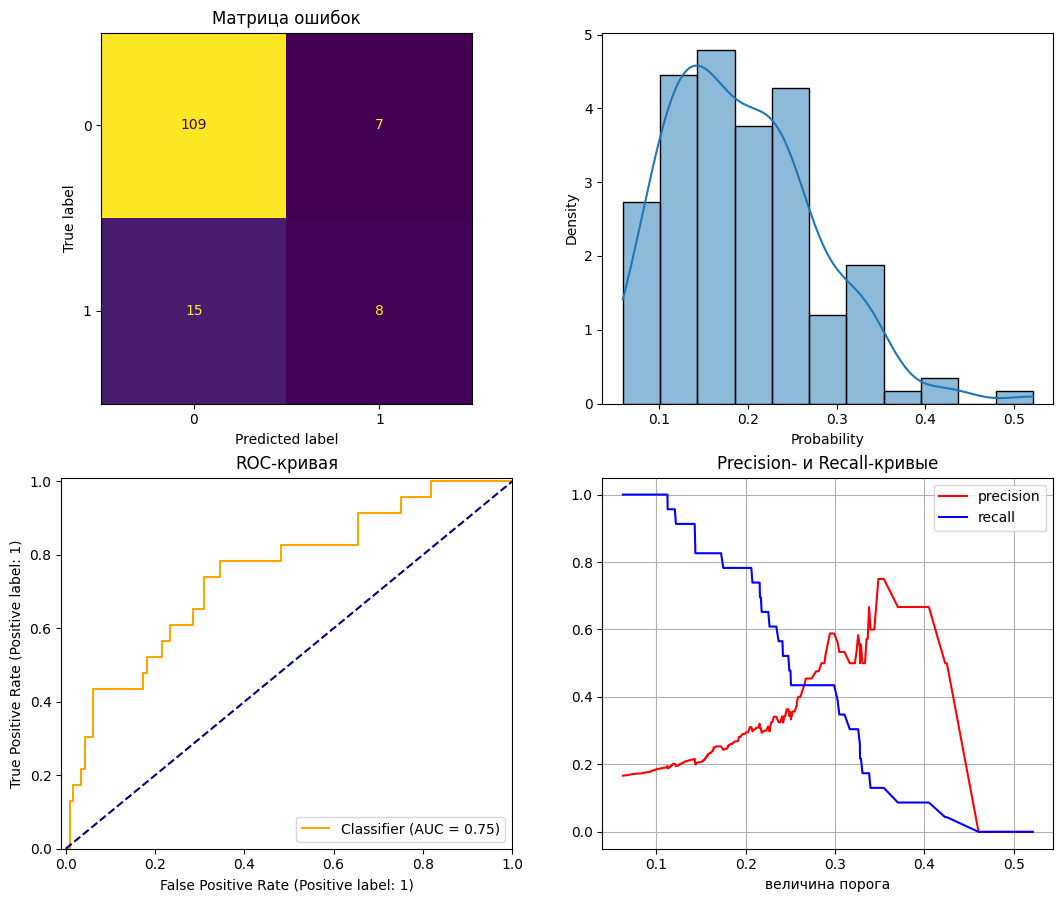

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       116
           1       0.53      0.35      0.42        23

    accuracy                           0.84       139
   macro avg       0.71      0.64      0.66       139
weighted avg       0.82      0.84      0.83       139

Индекс Gini = 0.4992503748125936


In [71]:
my_binary_classification_report(
    classifier=rf, X=X_august, y_true=y_august, threshold=0.313
)

## Gini std

In [45]:
calibrated_gini = [
    0.455223880597015,
    0.4616977225672876,
    0.40500000000000025,
    0.43457943925233655,
    0.4936281859070464,
]
round(np.std(calibrated_gini), 2)

0.03

In [72]:
norm_gini = [
    0.45003987695112224,
    0.45445134575569357,
    0.4033333333333333,
    0.40186915887850483,
    0.4992503748125936,
]
round(np.std(norm_gini), 2)

0.04

## Shap

In [17]:
X_new_shap = preprocess.transform(X_new)

In [18]:
X_new_shap.rename(columns=cols_dict, inplace=True)

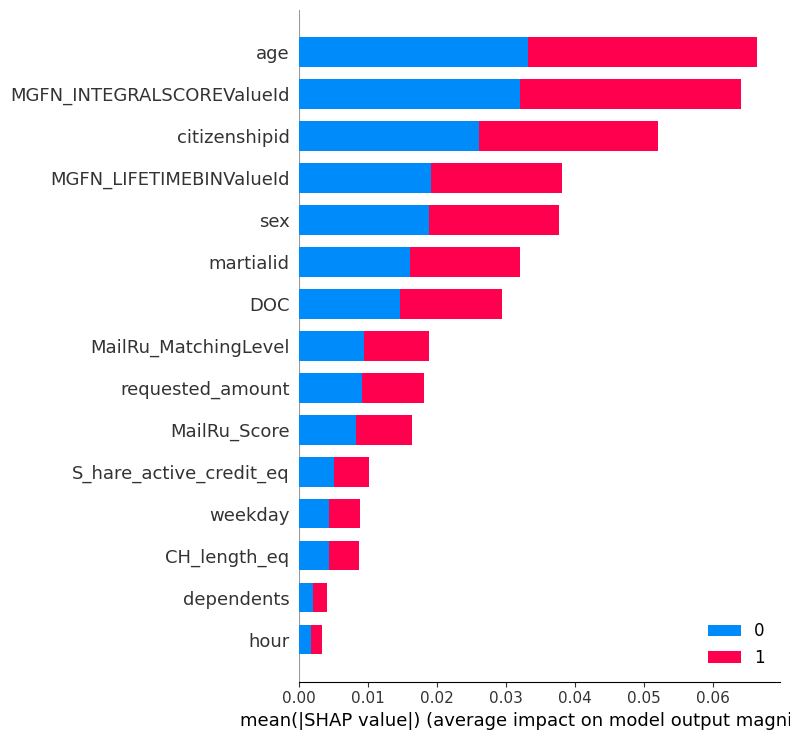

In [19]:
shap.summary_plot(
    shap_values=explainer.shap_values(X_new_shap),
    features=X_new_shap,
    class_names=[0, 1],
    max_display=15,
)